# **Serie de Tiempo - Forecasting**

1. Para los modelos AR desarrollados en las prácticas anteriores, genere un método que permita ajustar el modelo. El método debe recibir como argumento el algoritmo a utilizar (colocar alguno por defecto) y los datos con los que entrenará el modelo. Los algoritmos que debe implementar son OLS (Apóyese de una biblioteca para este ajuste) y Durbin-Levinson.
2. Para los modelos MA desarrollados en las prácticas anteriores, genere un método que permita ajustar el modelo. El método debe recibir como argumento los datos con los que entrenará el modelo. El algoritmo para entrenar el modelo debe ser Innovations.
3. Seleccione un dataset y ajuste un modelo AR y uno MA. Genere t predicciones (el t debe poder variar) con ambos modelos (usando el método de simulación desarrollado con anterioridad) y grafíquelas junto con los últimos k valores de la serie de tiempo.


In [ ]:

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import re
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [ ]:
#Uso de los métodos durbin-levinson y ols para obtener los mejores parámetros para el modelo autoregresivo
#params_phi: son todos los coeficientes del modelo de orden p
#alpha_const: una constante que forma parte del modelo autoregresivo
#p es el orden del modelo
#valor_serie: caracteristicas sobre la serie de tiempo en la cual queremos hacer el modelo

#Clase del modelo autoregresivo
class ModeloAutoregresivo:

  def __init__(self, p, algoritmo=None):
    self.p = p
    if algoritmo == None or algoritmo == 'OLS':
      self.algoritmo = self.alg_ols
    elif algoritmo == 'Durbin_Levinson':
      self.algoritmo = self.Durbin_Levinson

  def alg_ols(self,valor_serie, t):
    x, y = self.matrices_ols(valor_serie,t)
    modelo_ols = sm.OLS(y,x)
    resultados = modelo_ols.fit()
    phi = resultados.params
    #print(phi)
    return phi

  def Durbin_Levinson(self, valor_serie, t):
    #Autocorrelacion
    rho = np.zeros(self.p + 1)
    #y = np.array([valor_serie])
    y = valor_serie
    for h in range(self.p + 1):
      y1 = y[0:len(y)-h]
      y2 = y[h:len(y)]
      correlacion = np.corrcoef(y2, y1)
      rho[h] = correlacion[0,1]

    #Error
    P_error = np.zeros(self.p + 1)
    P_error[0]=np.var(np.array(valor_serie))

    #Matriz de phi
    matriz_phi = np.zeros((self.p + 1, self.p + 1))
    #print("CONSTRUCCION DE LA MATRIZ")
    for n in range(1, self.p + 1):
      sum_num = 0
      sum_den = 0
      for k in range(1,n):
        sum_num += matriz_phi[n-1,k] * rho[n-k]
        sum_den += matriz_phi[n-1,k] * rho[k]
      sum_num = rho[n] - sum_num
      sum_den = 1 - sum_den
      matriz_phi[n,n] = (sum_num)/(sum_den)
      #print(f"phi[{n},{n}] = {matriz_phi[n,n]}")
      if n>1:
        for k in range(1,n):
          matriz_phi[n,k]= matriz_phi[n-1,k] - (matriz_phi[n,n] * matriz_phi[n-1, n-k])
          #print(f"phi[{n},{k}] = {matriz_phi[n,k]}")
      P_error[n] = P_error[n-1] * (1 - pow(matriz_phi[n,n],2))

    #obtenido los valores optimos de phi
    phi = matriz_phi[self.p,1:]
    #print("Matriz phi: \n", matriz_phi)
    #print("Valores de phi ",phi)
    #print(f"Error: \n{P_error[self.p]}")
    return phi

  def matrices_ols(self, valor_serie,t):
    #print("Tamaño de serie de tiempo: ", np.shape(valor_serie))
    #print("valor de p: ", self.p)
    x = np.zeros((self.p,self.p))
    #print("Tamaño de x: ", np.shape(x))
    y = np.zeros(self.p)
    #print("Tamaño de y: ", np.shape(y))
    self.valor_serie = valor_serie
    for i in range(1,self.p +1): #columnas
      y[i-1] = valor_serie[t - (self.p + i)]
      for j in range(self.p): #filas
        x[j,i-1]= valor_serie[t-i-j]
    return x,y

  def modelo_autoregresivo_p(self, valor_serie,t):
    suma_val = 0
    ruido = np.random.normal(0,np.var(valor_serie),1)
    params_phi = self.algoritmo(valor_serie,t)
    self.params_phi= list(params_phi)
    print(f"Valore de phi: {self.params_phi}")
    for i,valor_phi in enumerate(self.params_phi):
      #comprobar que haya valores anteriores
      if t >= self.p:
        suma_val += valor_phi*valor_serie[t-(i+1)]
    Xt = suma_val
    return Xt

  def mostrar_polinomio(self, params_phi):
    self.params_phi = params_phi
    inicio_polinom =  f"X_t = 1"

    for i, valor_phi in enumerate(self.params_phi):
      inicio_polinom += f" - {valor_phi} z**{i+1}"

    #Obtener las raíces despues de haber extraido las raices
    params_phi = np.flip(params_phi)
    params_phi = params_phi * -1
    params_phi = np.append(params_phi,1)
    #print(params_phi)
    raices = np.roots(params_phi)
    return inicio_polinom, raices

  #verificar si se cumple que las raices, su valor absoluto es mayor a 1
  def es_causal(self,raices):
    for i in raices:
      if abs(i) > 1:
        print(f"La raíz {i} cumple con la condición (|raíz| > 1)")
      else:
        print(f"La raíz {i} no cumple con la condición (|raíz| > 1)")


In [ ]:
#Para la obetencio de los valores de phi se usa el método de Innovations
#params_phi: son todos los coeficientes del modelo de orden p
#alpha_const: una constante que forma parte del modelo autoregresivo
#p es el orden del modelo
#valor_serie: caracteristicas sobre la serie de tiempo en la cual queremos hacer el modelo
#Clase del modelo autoregresivo
class ModeloMediasMoviles:

  def __init__(self, q): #, params_theta = None): # alpha_const = 0,

    #self.alpha_const = alpha_const
    self.q = q

  def covarianza(self,x,h):
    prom = x.mean()
    result = 0
    x = x.transpose()
    for i in range(x.shape[0]-h):
        result += (x[i]-prom)*(x[i+h]-prom)
    return result / x.shape[0]

  def innovations_2(self, serie_tiempo):
    P_error = np.zeros(self.q +1)
    X = np.zeros(self.q + 1)
    matriz_theta = np.zeros((self.q + 1, self.q + 1))
    cov = np.zeros(self.q + 1)
    for i in range(0,self.q + 1):
      cov[i] = self.covarianza(np.array(serie_tiempo),i)
    P_error[0] = cov[0]
    print(f"Covarianza {cov}")

    #Vamos a empezar con los tetas
    #print("LLENADO DE MATRIZ DE THETAS")
    for t in range(1,self.q + 1):
      for j in range(0,t):
        sumatoria = 0
        for k in range(0,j):
          sumatoria += matriz_theta[j,j-k] * matriz_theta[t,t-k] * P_error[k]
        matriz_theta[t,t-j] = (cov[t-j] - sumatoria)/(P_error[j])
        #print(f"matriz_theta[{t},{t-j}] = {matriz_theta[t,t-j]}")
      #Para el error
      suma_perror = 0
      for j in range(0,t):
        suma_perror += pow(matriz_theta[t,t-j],2) * P_error[j]
      P_error[t] = cov[0] - suma_perror

      #Para los valores de x
      suma_x = 0
      #print(f"ESTAMOS EN LA SUMA DE X para el calculo de X{t}")
      for j in range(1,t+1):
        suma_x += matriz_theta[t,j] * (serie_tiempo[self.t - j] - X[t-j])
      X[t]=suma_x
    thetas = matriz_theta[self.q,1:]
    print(f"Error: {P_error[self.q]}")
    return thetas

  def modelo_mediaMovil_q(self, valor_serie,t):
    suma_val = 0
    #para los datos obserrvados dice que literalmetne se suma con la serie
    ruido = np.random.normal(0,np.var(valor_serie),len(valor_serie))
    self.t = t
    wt = ruido

    #print(self.params_phi)
    thetas = self.innovations_2( list(valor_serie))
    self.params_theta= list(thetas)
    print(f"Valores de theta {self.params_theta}")
    for i,valor_theta in enumerate(self.params_theta):
      #comprobar que haya valores anteriores
      if t >= self.q:
        suma_val += valor_theta*wt[t-(i+1)]
    Xt =  suma_val
    return Xt

  def mostrar_polinomio(self, params_theta):
    self.params_theta = params_theta
    inicio_polinom =  f"X_t = 1 "
    for i, valor_theta in enumerate(self.params_theta):
      inicio_polinom += f" + {valor_theta} z**{i+1}"
    parametros = np.flip(self.params_theta)
    parametros = list(parametros) + [1]
    print(parametros)
    parametros = np.array(parametros)
    raices = np.roots(parametros)
    return inicio_polinom, raices


  def es_invertible(self,raices):
    N=len(raices)
    suma=0
    for i in raices:
      if abs(i)>1:
        print(abs(i))
        suma+=1
    if suma==N:
      print("Es invertible")
    else:
      print("No es invertible")





# **Aplicación a dataset de consumo electrico** ⚡

In [ ]:
elctricidad = pd.read_csv("/content/consumo_electricidad.csv")
print(elctricidad)

           Fecha  Consumo_Electricidad
0     2020-01-01            506.927401
1     2020-01-02            496.326312
2     2020-01-03            495.324197
3     2020-01-04            502.001669
4     2020-01-05            503.787590
...          ...                   ...
1090  2022-12-26            554.986555
1091  2022-12-27            544.398296
1092  2022-12-28            550.527186
1093  2022-12-29            552.645713
1094  2022-12-30            554.498254

[1095 rows x 2 columns]


In [ ]:
#Haciendo estacioanria la serie de tiempo
columnas_a_escalas = ['Consumo_Electricidad']
datos_a_escalas = elctricidad[columnas_a_escalas]
escalador = StandardScaler()
datos_escalados = escalador.fit_transform(datos_a_escalas)
df_escalado = pd.DataFrame(datos_escalados, columns=columnas_a_escalas)
elctricidad_diferenciado = df_escalado.diff().dropna()

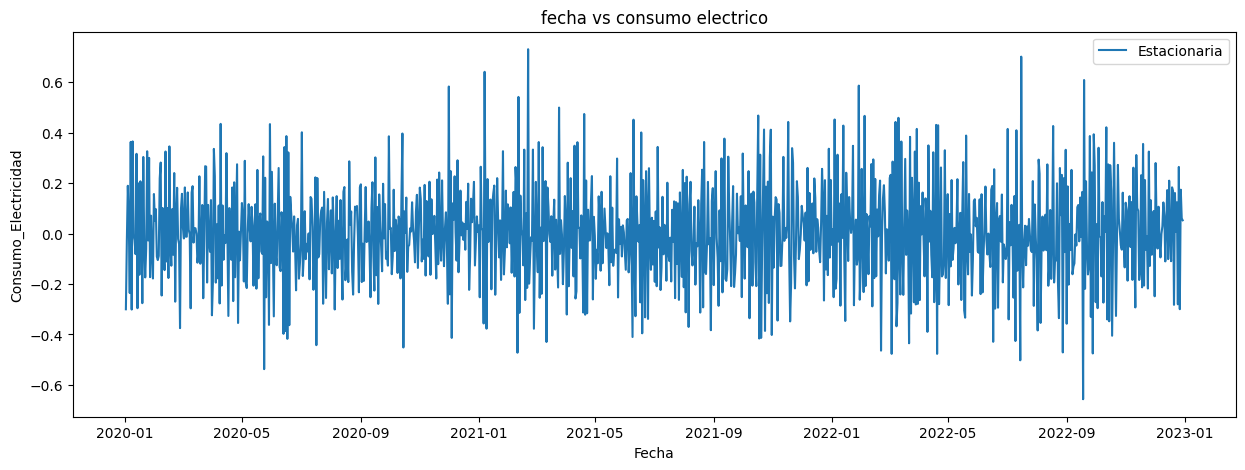

In [ ]:
elctricidad['Fecha'] = pd.to_datetime(elctricidad['Fecha'])
_fig_, _axs_ = plt.subplots(nrows = 1, figsize = (15, 5))
_fig_.subplots_adjust(hspace = 0.3, wspace = 0.3)
_axs_.set(title = "fecha vs consumo electrico")
_ = sns.lineplot(x = elctricidad["Fecha"], y = elctricidad_diferenciado['Consumo_Electricidad'], label = "Estacionaria", ax = _axs_)

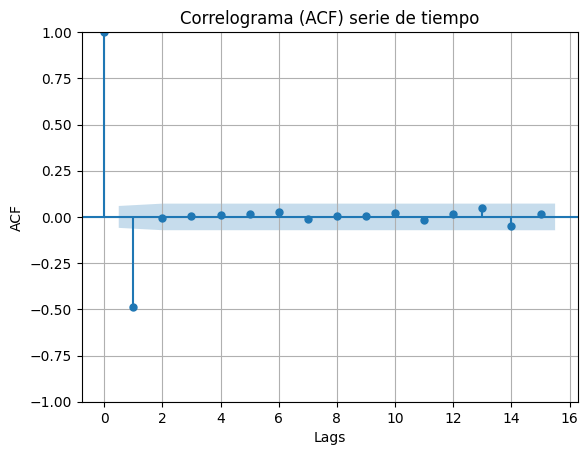

In [ ]:
#Uso de ACF para saber el orden del modelo de medias moviles
plot_acf(elctricidad_diferenciado['Consumo_Electricidad'], lags = 15)

plt.title('Correlograma (ACF) serie de tiempo')
plt.xlabel('Lags')
plt.ylabel('ACF')
plt.grid(True)
plt.show()

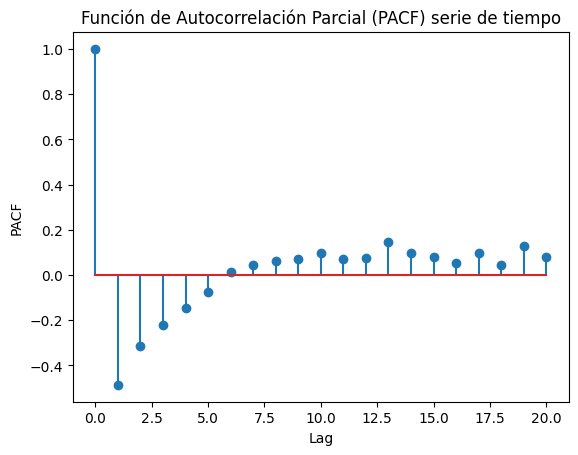

In [ ]:
#Uso de PACF para obtener el orden del modelo de Autoregresión
acf_array, confint = sm.tsa.pacf(elctricidad_diferenciado['Consumo_Electricidad'], nlags=20, alpha=0.05)
plt.stem(acf_array)
plt.title('Función de Autocorrelación Parcial (PACF) serie de tiempo')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

In [ ]:
#Prueba para OLS

temp_1 = list(elctricidad_diferenciado.iloc[0:1085,0])
modelo_arp_ols = ModeloAutoregresivo(6, algoritmo ='OLS' )
Xt = modelo_arp_ols.modelo_autoregresivo_p(temp_1, 1085)
print(f"Valor predicho para el tiempo {1085} con OLS: {Xt}")

Valore de phi: [0.7393700575721153, 0.5699490271572893, 0.052107626663594364, -0.20561232056408904, -0.302951416399729, -0.10857594409515964]
Valor predicho para el tiempo 1085 con OLS: [-0.13957122]


In [ ]:
#Prueba para Durbin Levison
temp_2 = list(elctricidad_diferenciado.iloc[0:1085,0])
modelo_arp_DL = ModeloAutoregresivo(6, algoritmo ='Durbin_Levinson' )
Xt = modelo_arp_DL.modelo_autoregresivo_p(temp_2, 1085)
print(f"Valor predicho para el tiempo {1085} con Durbin Levinson: {Xt}")

Error: 
0.025542324643770976
Valore de phi: [-0.7506092479747977, -0.5474373295440238, -0.36054175334299854, -0.19624119413488061, -0.06497299567270912, 0.011058959333095588]
Valor predicho para el tiempo 1085 con Durbin Levinson: [0.05903573]


In [ ]:
valores_pred = []
temp_2 = list(elctricidad_diferenciado.iloc[0:1085,0])
modelo_arp_DL = ModeloAutoregresivo(6, algoritmo ='Durbin_Levinson' )
Xt = modelo_arp_DL.modelo_autoregresivo_p(temp_2, 1085)
temp_2.append(Xt[0])
valores_pred.append(Xt)
print(f"Tipo de temp_2: ", type(temp_2))
print(f"Tamaño: {len(temp_2)}")
print(f"Valor de Xt: ", Xt)
print(f"Tipo de Xt: {type(Xt)}")
print(f"Tamaño de Xt: {np.shape(Xt)}")
modelo_arp_DL = ModeloAutoregresivo(6, algoritmo ='Durbin_Levinson' )
Xt = modelo_arp_DL.modelo_autoregresivo_p(temp_2, 1086)
temp_2.append(Xt[0])
valores_pred.append(Xt)


Error: 
0.025542324643770976
Valore de phi: [-0.7506092479747977, -0.5474373295440238, -0.36054175334299854, -0.19624119413488061, -0.06497299567270912, 0.011058959333095588]
Tipo de temp_2:  <class 'list'>
Tamaño: 1086
Valor de Xt:  [0.05931273]
Tipo de Xt: <class 'numpy.ndarray'>
Tamaño de Xt: (1,)
Error: 
0.025555214812385103
Valore de phi: [-0.7491607804599864, -0.5449080701320272, -0.35755533611702, -0.19364929279530307, -0.0630383201314065, 0.012261340716591542]


In [ ]:
#Predicciones

temp_2 = list(elctricidad_diferenciado.iloc[0:995,0])
valores_pred = []
for j in range(995,1095):
  modelo_arp_DL = ModeloAutoregresivo(6, algoritmo ='Durbin_Levinson' )
  Xt = modelo_arp_DL.modelo_autoregresivo_p(temp_2, int(j))
  temp_2.append(Xt)
  valores_pred.append(Xt)
  print(f"Xt: {Xt}")

Valore de phi: [-0.7412596668049172, -0.5351979031367716, -0.3450588365964819, -0.19958485544937454, -0.07733251131606991, 0.001885590899045946]
Xt: -0.06659296280187522
Valore de phi: [-0.741618742210942, -0.5361422324651894, -0.34614539595957, -0.20123976104812116, -0.07786217471979887, 0.0016355785378158315]
Xt: 0.001525302752305063
Valore de phi: [-0.7415619349808706, -0.536115432925588, -0.3462036519129435, -0.20142623577644717, -0.07818611285096991, 0.0012663817713697333]
Xt: 0.02894175581307249
Valore de phi: [-0.7416300341388341, -0.5362351421274046, -0.3462738140337766, -0.20128924792558922, -0.07804981812716254, 0.0015967613976281428]
Xt: -0.00516720908440862
Valore de phi: [-0.7416168044381697, -0.5362170710019961, -0.3462545503390423, -0.2012857114942853, -0.07808863961261105, 0.0015693484236814915]
Xt: 0.005606277502884266
Valore de phi: [-0.7416157533211161, -0.5362160213917975, -0.3462630876723814, -0.20131081410950927, -0.07811760127871642, 0.0015612786066319367]
Xt: -0

In [ ]:
print(elctricidad_diferenciado['Consumo_Electricidad'])

1      -0.300205
2      -0.028378
3       0.189094
4       0.050574
5      -0.235797
          ...   
1090    0.263722
1091   -0.299841
1092    0.173560
1093    0.059993
1094    0.052461
Name: Consumo_Electricidad, Length: 1094, dtype: float64


In [ ]:
Fecha = elctricidad['Fecha'].drop(0)

In [ ]:
print(temp_2[1090:1095])
print(elctricidad_diferenciado['Consumo_Electricidad'].loc[1090:1094])
print(elctricidad_diferenciado['Consumo_Electricidad'].loc[1093])
print(len(elctricidad_diferenciado['Consumo_Electricidad']))
print(len(elctricidad["Fecha"]))

[-0.1034761226070471, 0.024211798332748922, -0.030428658870197668, 0.019126021774985336, 0.027648410048724842]
1090    0.263722
1091   -0.299841
1092    0.173560
1093    0.059993
1094    0.052461
Name: Consumo_Electricidad, dtype: float64
0.05999303109039833
1094
1095


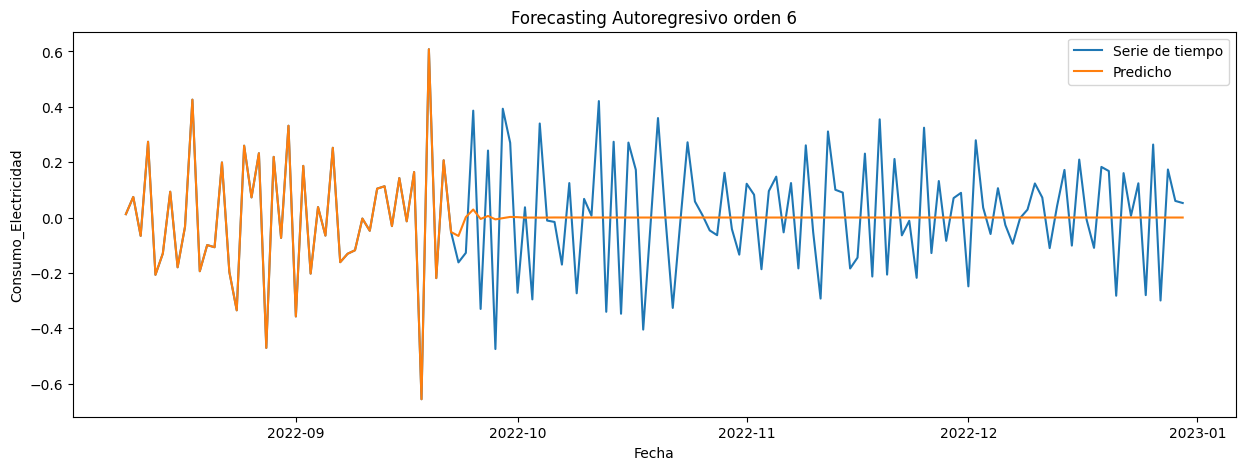

In [ ]:
elctricidad['Fecha'] = pd.to_datetime(elctricidad['Fecha'])
_fig_, _axs_ = plt.subplots(nrows = 1, figsize = (15, 5))
_fig_.subplots_adjust(hspace = 0.3, wspace = 0.3)
_axs_.set(title = "Forecasting Autoregresivo orden 6")
_ = sns.lineplot(x = Fecha.iloc[950:1095], y = elctricidad_diferenciado['Consumo_Electricidad'].iloc[950:1095], label = "Serie de tiempo", ax = _axs_)
_ = sns.lineplot(x = Fecha.iloc[950:1095], y = temp_2[950:1094], label = "Predicho", ax = _axs_)

Medias Moviles Innovations

In [ ]:
temp_2 = list(elctricidad_diferenciado.iloc[0:1084,0])
print(temp_2[1083])
modelo_MM = ModeloMediasMoviles(3)
Xt = modelo_MM.modelo_mediaMovil_q(temp_2,1084)
print(f"Valor predicho: {Xt}")

0.1679878771217138
Covarianza [ 0.04005744 -0.01935188 -0.00027586  0.00022071]
Error: 0.026383243072849838
Valores de theta [-0.7026532736968443, -0.005511053998216734, 0.005509957157210992]
Valor predicho: -0.9352502722120919


In [ ]:
elc_MM = list(elctricidad_diferenciado.iloc[0:995,0])
valores_pred_m = []
for j in range(995,1095):
  modelo_MM = ModeloMediasMoviles(2)
  Xt = modelo_MM.modelo_mediaMovil_q(elc_MM,j)
  elc_MM.append(Xt)
  valores_pred_m.append(Xt)

Covarianza [ 0.03993856 -0.01925537 -0.00040691]
Error: 0.027591815881578944
Valores de theta [-0.6345299449400614, -0.010188485086898654]
Covarianza [ 0.03989945 -0.0192377  -0.00039999]
Error: 0.027566939359458715
Valores de theta [-0.634490060422125, -0.010025020348213565]
Covarianza [ 0.03985943 -0.01921847 -0.00039948]
Error: 0.02753925653186927
Valores de theta [-0.6344916928943707, -0.010022182568338726]
Covarianza [ 0.03982049 -0.01919929 -0.0003981 ]
Error: 0.02751365221081044
Valores de theta [-0.6344546146794409, -0.009997266716548646]
Covarianza [ 0.03978227 -0.01917881 -0.0003978 ]
Error: 0.0274906300796164
Valores de theta [-0.6343465971237945, -0.009999366587097526]
Covarianza [ 0.03974344 -0.01915839 -0.00039644]
Error: 0.027467243745191716
Valores de theta [-0.6342410027094245, -0.009974911280078338]
Covarianza [ 0.03970437 -0.01913848 -0.00039503]
Error: 0.02744266591198303
Valores de theta [-0.6341680323847759, -0.009949358923433276]
Covarianza [ 0.03966479 -0.019119

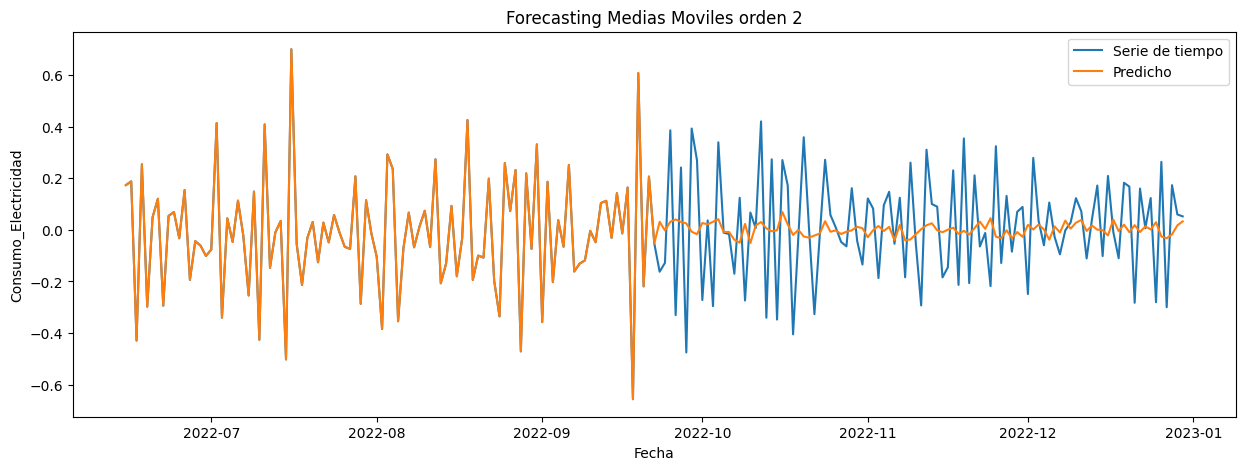

In [ ]:
elctricidad['Fecha'] = pd.to_datetime(elctricidad['Fecha'])
_fig_, _axs_ = plt.subplots(nrows = 1, figsize = (15, 5))
_fig_.subplots_adjust(hspace = 0.3, wspace = 0.3)
_axs_.set(title = "Forecasting Medias Moviles orden 2")
_ = sns.lineplot(x = Fecha.iloc[895:1095], y = elctricidad_diferenciado['Consumo_Electricidad'].iloc[895:1095], label = "Serie de tiempo", ax = _axs_)
_ = sns.lineplot(x = Fecha.iloc[895:1095], y = elc_MM[895:1094], label = "Predicho", ax = _axs_)

In [ ]:
#Verificación del uso de los métodos mediante el uso de librerias

In [ ]:
import statsmodels
datos = list(elctricidad_diferenciado.iloc[0:1080,0])
acov = sm.tsa.acovf(datos)
acov_aux = acov[:3]

In [ ]:
theta, sigma2  =statsmodels.tsa.stattools.innovations_algo(acov_aux)

In [ ]:
print(theta)

[[ 0.          0.        ]
 [-0.48413269  0.        ]
 [-0.63608925 -0.00592217]]


In [ ]:
modelo_MM = ModeloMediasMoviles(2)
Xt = modelo_MM.modelo_mediaMovil_q(datos,1080)

Covarianza [ 0.04013801 -0.01943212 -0.0002377 ]
Error: 0.027702835543050853
Valores de theta [-0.6360892474357246, -0.005922172269078463]


In [ ]:
acov = sm.tsa.acovf(datos)
a, b, c, d, phi = statsmodels.tsa.stattools.levinson_durbin(acov, nlags = 3, isacov=True)
print(phi)

[[ 0.          0.          0.          0.        ]
 [ 0.         -0.48413269 -0.63608925 -0.70488051]
 [ 0.          0.         -0.31387377 -0.45328454]
 [ 0.          0.          0.         -0.21916856]]


In [ ]:
print(b)

[-0.70488051 -0.45328454 -0.21916856]


In [ ]:
modelo_arp_DL = ModeloAutoregresivo(3, algoritmo ='Durbin_Levinson' )
Xt = modelo_arp_DL.modelo_autoregresivo_p(datos, 1080)

Valore de phi: [-0.7072675450482371, -0.4559365010356776, -0.22080322848186665]
